# Facies classification using Machine Learning

### [Original contest notebook](../Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)

Let's train some data. I'm [Jesper](http://twitter.com/JesperDramsch) and I have [no clue what I'm doing](https://the-geophysicist.com/seg-machine-learning-contest) but I'm having fun. Most texts are still from the original notebook from Brandon Hall. As well as the basis for the code.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import s2sphere as s2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None

def distance(latlon1,latlon2):
    lat1 = np.deg2rad(latlon1[0])
    lon1 = np.deg2rad(latlon1[1])
    lat2 = np.deg2rad(latlon2[0])
    lon2 = np.deg2rad(latlon2[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return (6371 * c)

facies_labels = ['SS','CSiS','FSiS','SiSh','MS','WS','D','PS','BS']
facies = pd.DataFrame({'ShortName': pd.Series(facies_labels,index=facies_labels),'Facies' : pd.Series(['Nonmarine sandstone', 'Nonmarine coarse siltstone', 'Nonmarine fine siltstone ', 'Marine siltstone and shale', 'Mudstone (limestone)',  'Wackestone (limestone)', 'Dolomite', 'Packstone-grainstone (limestone)','Phylloid-algal bafflestone (limestone)'],index=facies_labels), 'Neighbours' : pd.Series(['CSiS',['SS','FSiS'],'CSiS','MS',['SiSh','WS'],['MS','D'],['WS','PS'],['WS','D','BS'],['D','PS']],index=facies_labels), 'Colors' : pd.Series(['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D'],index=facies_labels)})

filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


Verbatim from Brendon Hall:
> This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 

In [2]:
facies[['Facies']]

,Facies
SS,Nonmarine sandstone
CSiS,Nonmarine coarse siltstone
FSiS,Nonmarine fine siltstone
SiSh,Marine siltstone and shale
MS,Mudstone (limestone)
WS,Wackestone (limestone)
D,Dolomite
PS,Packstone-grainstone (limestone)
BS,Phylloid-algal bafflestone (limestone)


These facies gradually blend into one another. We can see a marine non-marine neighbourhood already.

In [3]:
pd.DataFrame({'Neighbours' : [facies.ShortName[x] for x in facies.Neighbours]},index=facies_labels)


,Neighbours
SS,CSiS
CSiS,"SS SS FSiS FSiS Name: ShortName, dty..."
FSiS,CSiS
SiSh,MS
MS,"SiSh SiSh WS WS Name: ShortName, dty..."
WS,"MS MS D D Name: ShortName, dtype: object"
D,"WS WS PS PS Name: ShortName, dtype: object"
PS,"WS WS D D BS BS Name: ShortName, dt..."
BS,"D D PS PS Name: ShortName, dtype: object"


The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [4]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

Shrimplin: 
* Longitude: -100.98329 
* Latitude: 37.98126 

ALEXANDER D
* Longitude: -95.3534525 
* Latitude: 37.6607787 

SHANKLE
* Longitude: -101.3891894 
* Latitude: 38.0633727 

LUKE G U
* Longitude: -101.6073725 
* Latitude: 37.4537739 

KIMZEY A
* Longitude: -101.39697 
* Latitude: 37.12289 

CROSS H CATTLE
* Longitude: -101.6464517 
* Latitude: 37.9105826 

NOLAN
* Longitude: -101.0451641 
* Latitude: 37.7866294 

Recruit F9


NEWBY
* Longitude: -101.5847635 
* Latitude: 37.5406739 

CHURCHMAN BIBLE
* Longitude: -101.1060761 
* Latitude: 37.3497658 

STUART
* Longitude: -101.1391063 
* Latitude: 37.4857262 

CRAWFORD
* Longitude: -101.1494994 
* Latitude: 37.1893654 

In [5]:
latlong = pd.DataFrame({"SHRIMPLIN": [37.98126,-100.98329], "ALEXANDER D": [37.6607787,-95.3534525], "SHANKLE": [38.0633727,-101.3891894], "LUKE G U": [37.4537739,-101.6073725], "KIMZEY A": [37.12289,-101.39697], "CROSS H CATTLE": [37.9105826,-101.6464517], "NOLAN": [37.7866294,-101.0451641], "NEWBY": [37.5406739,-101.5847635], "CHURCHMAN BIBLE": [37.3497658,-101.1060761], "STUART": [37.4857262,-101.1391063], "CRAWFORD": [37.1893654,-101.1494994], "Recruit F9": [37.4,-101]})
#distance([37.660779,-95.353453],[37.349766,-101.106076])
dist_mat= pd.DataFrame(np.zeros((latlong.shape[1],latlong.shape[1])))
#dist_mat = np.zeros(len(latlong.index),len(latlong.index))
"""
for i,x in enumerate(latlong):
    for j,y in enumerate(latlong):
        if i > j:
            dist_mat[i][j] = (distance(latlong[x].values,latlong[y].values))
            dist_mat[j][i] = dist_mat[i][j]
"""
s2cell = pd.DataFrame()

for  num in range(7,11):
    cell = pd.DataFrame()
    for wells in latlong:
        temp = pd.DataFrame({wells: [s2.CellId().from_lat_lng(s2.LatLng.from_degrees(latlong[wells][0],latlong[wells][1])).parent(num).id()]}, index=['s2_'+str(num)])  
        cell  = pd.concat([cell, temp], axis=1)
    s2cell = pd.concat([s2cell, cell.T], axis=1)

s2cell

,s2_7,s2_8,s2_9,s2_10
ALEXANDER D,9779636959579209728,9779689736137342976,9779685338090831872,9779682039555948544
CHURCHMAN BIBLE,9730097363678134272,9730114955864178688,9730110557817667584,9730113856352550912
CRAWFORD,9730097363678134272,9730114955864178688,9730101761724645376,9730100662213017600
CROSS H CATTLE,9730378838654844928,9730431615212978176,9730418421073444864,9730421719608328192
KIMZEY A,9730238101166489600,9730290877724622848,9730295275771133952,9730296375282761728
...,...,...,...,...
NOLAN,9730519576143200256,9730501983957155840,9730515178096689152,9730518476631572480
Recruit F9,9730097363678134272,9730114955864178688,9730110557817667584,9730109458306039808
SHANKLE,9730378838654844928,9730431615212978176,9730444809352511488,9730448107887394816
SHRIMPLIN,9730519576143200256,9730466799585067008,9730462401538555904,9730463501050183680


In [6]:
training_data.describe()

C:\Users\Jesper\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


The new data set contains about 1000 data points or 33% more than the original one. Rejoice!

In [7]:
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies.Colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] ]
    
training_data['Facies'] = training_data['Facies']-1
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

rows = len(training_data.index)

processed_data = training_data.copy()

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [8]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies.Colors[0:len(facies.Colors)], 'indexed')
    cmap_coarse = colors.ListedColormap(['#c0c0c0','#000000'])
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    clustercoarse=np.repeat(np.expand_dims(logs['NM_M'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    
    
    im1 = ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=8)
    im2 = ax[6].imshow(clustercoarse, interpolation='none', aspect='auto',
                    cmap=cmap_coarse,vmin=0,vmax=1)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im1, cax=cax)
    cbar.set_label((18*' ').join(facies.index))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('NM_M')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    plt.show()

Here's the `SHRIMPLIN` well for your vieling pleasure.

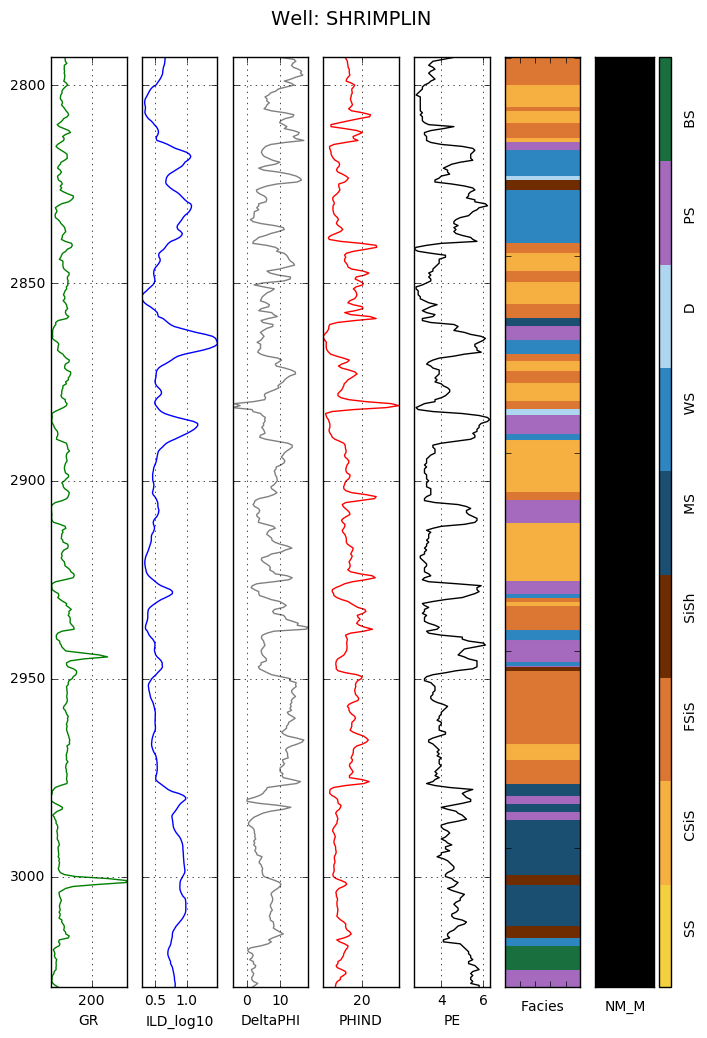

In [9]:
make_facies_log_plot(
    processed_data[processed_data['Well Name'] == 'SHRIMPLIN'],
    facies.Colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

,SS,CSiS,FSiS,SiSh,MS,WS,D,PS,BS
Facies,268,940,780,271,296,582,141,686,185


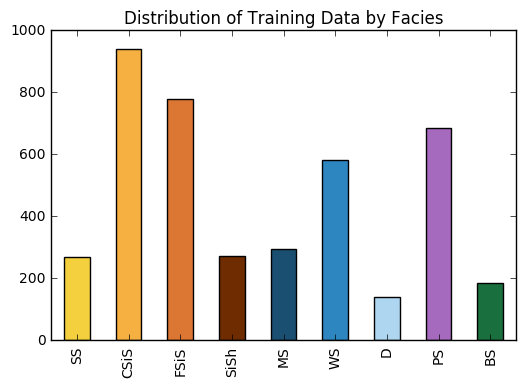

In [10]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = processed_data['Facies'].value_counts().sort_index()
tmp = processed_data.query('NM_M==1')
facies_counts0 = tmp['Facies'].value_counts().sort_index()

tmp = processed_data.query('NM_M==2')
facies_counts1 = tmp['Facies'].value_counts().sort_index()

#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies.Colors, 
                   title='Distribution of Training Data by Facies')
pd.DataFrame(facies_counts).T

This shows the distribution of examples by facies for the examples in the training set.  Dolomite (facies 7) has the fewest with 81 examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

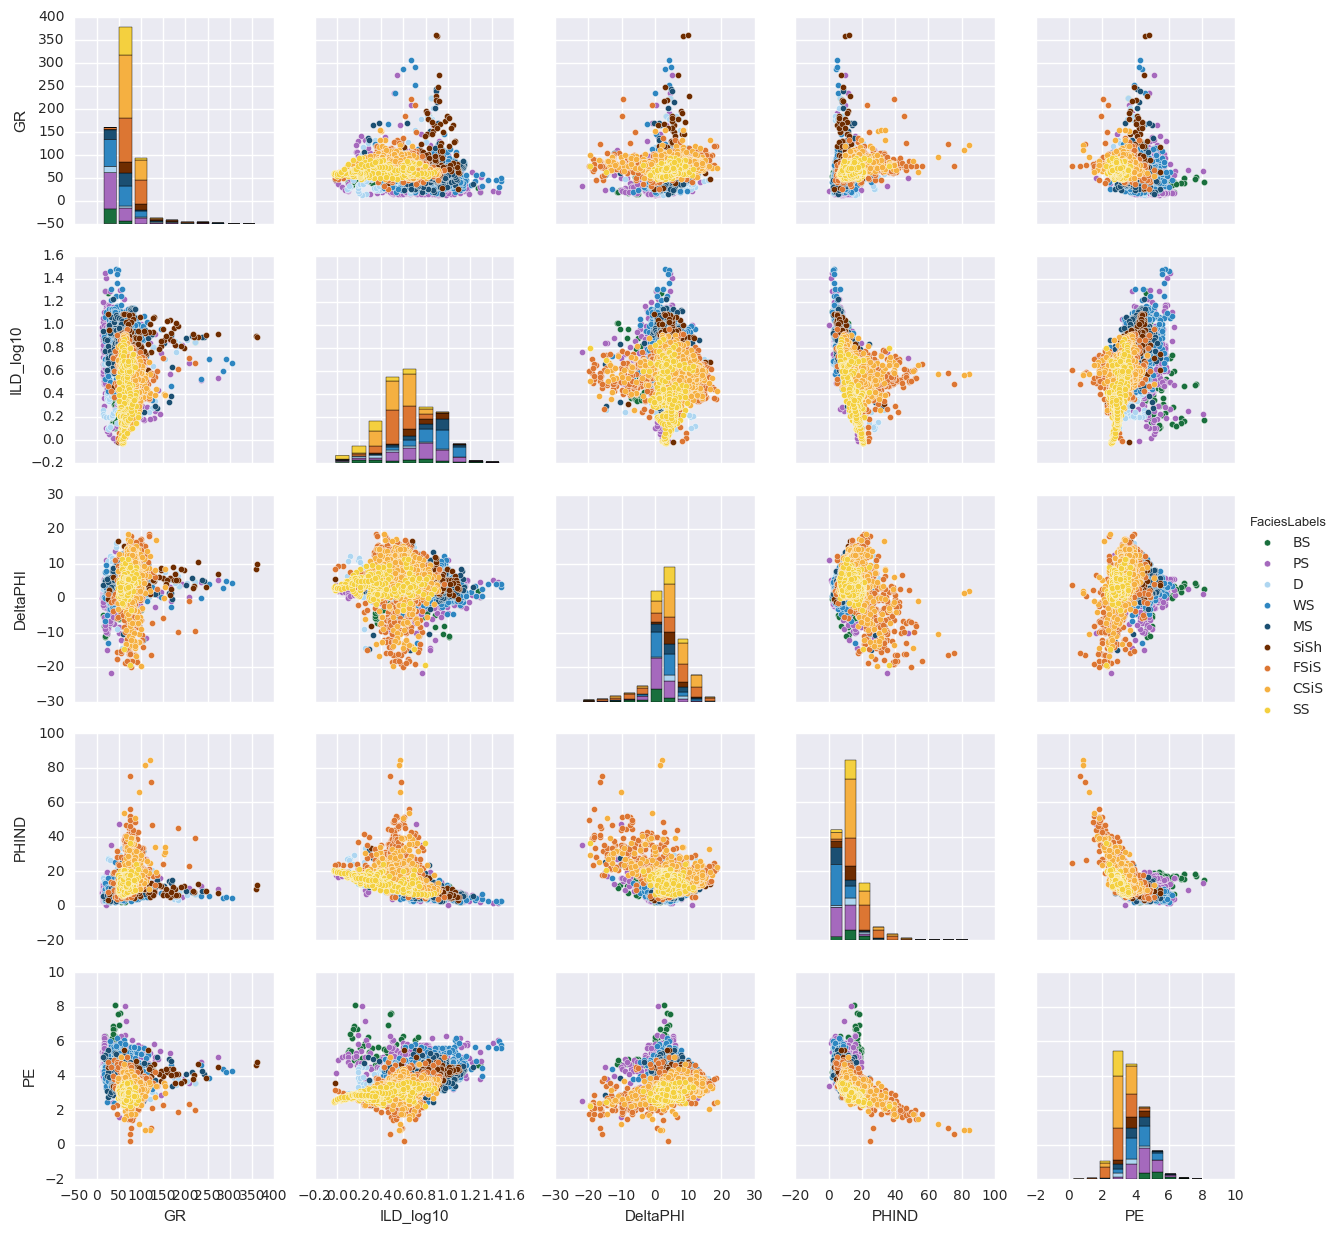

In [282]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
plotdata=processed_data.drop(['Well Name','Formation','Depth','RELPOS'],axis=1).dropna()

sns.pairplot(plotdata.drop(['Facies','NM_M'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

At this point I woult like to take a look at the separated main classes. 

,0,1,2,3,4,5,6,7
Facies,268,934,764,5,11,3,1,12


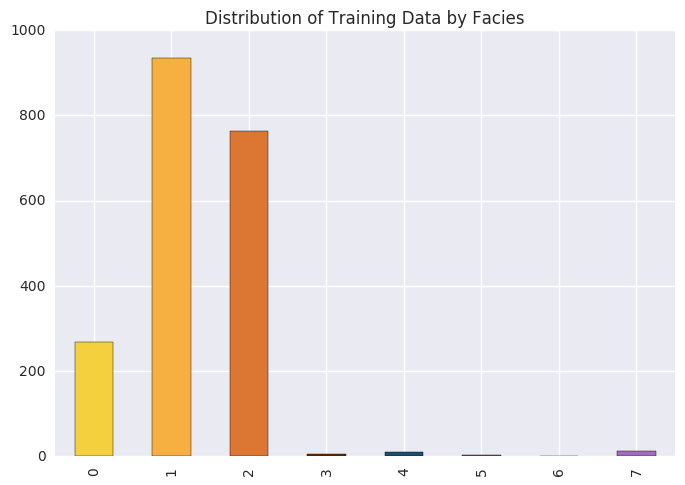

In [283]:
facies_counts0.plot(kind='bar',color=facies.Colors, 
                   title='Distribution of Training Data by Facies')
pd.DataFrame(facies_counts0).T

,1,2,3,4,5,6,7,8
Facies,6,16,266,285,579,140,674,185


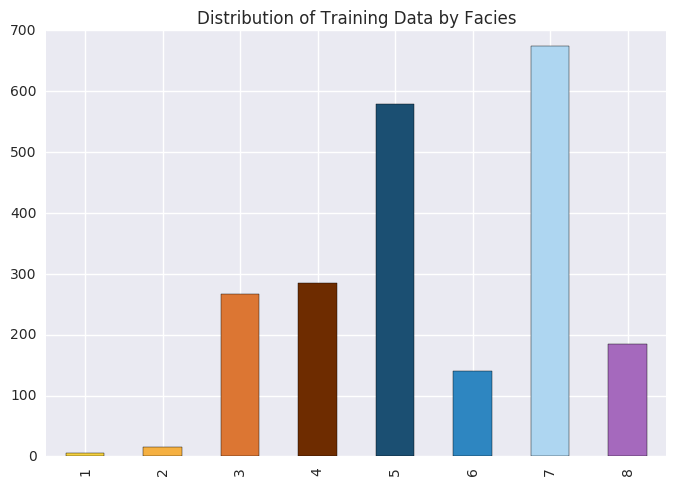

In [284]:
facies_counts1.plot(kind='bar',color=facies.Colors, 
                   title='Distribution of Training Data by Facies')
pd.DataFrame(facies_counts1).T

# Preprocessing

In [11]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy import signal


enc = preprocessing.OneHotEncoder()
le = preprocessing.LabelEncoder()
imp = preprocessing.Imputer(missing_values='NaN',strategy="mean",axis=0)

#processed_data['NM_M'] = enc.fit(processed_data[['NM_M']]).transform(processed_data[['NM_M']]).toarray()

training_data= training_data[training_data['PE'].notnull().values]
correct_facies_labels  = processed_data['Facies'].values
correct_facies_labels_comp = training_data['Facies'].values
for key in s2cell.keys():
    s2cell[key] = le.fit(s2cell[key]).transform(s2cell[key])
print(s2cell)
feature_vectors_comp = training_data.drop(['Formation', 'Well Name','Depth','Facies','FaciesLabels'], axis=1)

#scaler = preprocessing.StandardScaler().fit(feature_vectors)
#scaled_features = scaler.transform(feature_vectors)
scaler_comp = preprocessing.StandardScaler().fit(feature_vectors_comp)
scaled_features_comp = scaler_comp.transform(feature_vectors_comp)


                 s2_7  s2_8  s2_9  s2_10
ALEXANDER D         4     6     9     11
CHURCHMAN BIBLE     0     0     1      2
CRAWFORD            0     0     0      0
CROSS H CATTLE      2     3     4      6
KIMZEY A            1     1     2      3
...               ...   ...   ...    ...
NOLAN               3     5     8     10
Recruit F9          0     0     1      1
SHANKLE             2     3     5      7
SHRIMPLIN           3     4     6      8
STUART              3     5     7      9

[12 rows x 4 columns]


## Feature Engineering

Let's get some filters going.

In [12]:
def feature_eng(input_data):
    logger = []
    feature_vectors = input_data.drop(['Formation','Depth'], axis=1)
    #feature_vectors['Well Name'] = le.fit(feature_vectors['Well Name']).transform(feature_vectors['Well Name'])
    #feature_vectors = pd.DataFrame(imp.fit(feature_vectors).transform(feature_vectors), columns=feature_vectors.columns)
    tmp1 = feature_vectors['Well Name']
    tmp2 = feature_vectors.drop(['Well Name'], axis=1)
    tmp3 = pd.DataFrame(imp.fit(tmp2).transform(tmp2), columns=tmp2.columns)
    feature_vectors = pd.concat([tmp1,pd.DataFrame(preprocessing.StandardScaler().fit(tmp3).transform(tmp3), columns=tmp3.columns)],axis=1)
    b, a = signal.butter(5, [0.1,0.9], btype='bandstop')
    for well, logs in feature_vectors.groupby(['Well Name'],sort=False):
        log_raw = []    
        log_out = []
        log_raw = logs.drop(['Well Name','RELPOS','NM_M'], axis=1)
        for xn in log_raw:
            log_out.append(pd.DataFrame({xn: logs[xn]},index=[logs.index]))
            log_out.append(pd.DataFrame({xn+'_smooth': signal.filtfilt(b,a,logs[xn])},index=[logs.index])) #butterworth filter
        log_smooth=pd.concat(log_out,axis=1)
        for xn in log_smooth:
            log_out.append(pd.DataFrame({xn+'_median': signal.medfilt(log_smooth[xn],13)},index=[logs.index])) #median filter
            log_out.append(pd.DataFrame({xn+'_d1': signal.savgol_filter(log_smooth[xn], window_length=9, polyorder=3, deriv=1, delta=1, mode='nearest')},index=[logs.index])) #first derivative on noisy data
            log_out.append(pd.DataFrame({xn+'_d2': signal.savgol_filter(log_smooth[xn], window_length=9, polyorder=3, deriv=2, delta=1, mode='nearest')},index=[logs.index])) #second derivative on noisy data
            log_out.append(pd.DataFrame({xn+'_analytical': np.imag(signal.hilbert(log_smooth[xn]))},index=[logs.index])) #analytical filter
        for key in s2cell.keys():
            log_out.append(pd.DataFrame({key: [s2cell[key][well]]*len(log_smooth[xn])},index=[logs.index]))
        log_fe = pd.concat(log_out,axis=1)
        logger.append(log_fe)
    tmp = pd.concat(logger, axis=0, ignore_index=True)
    feature_vectors= pd.concat([tmp,feature_vectors['NM_M'],feature_vectors['RELPOS']], axis=1)
    for key in s2cell.keys():
        feature_vectors[key] = feature_vectors[key].astype('category')
    return feature_vectors
feature_vectors = feature_eng(processed_data.drop(['Facies','FaciesLabels'], axis=1))
feature_vectors

,GR,GR_smooth,ILD_log10,ILD_log10_smooth,DeltaPHI,DeltaPHI_smooth,PHIND,PHIND_smooth,PE,PE_smooth,...,PE_smooth_median,PE_smooth_d1,PE_smooth_d2,PE_smooth_analytical,s2_7,s2_8,s2_9,s2_10,NM_M,RELPOS
0,0.413085,0.409209,0.017549,0.019215,1.042319,1.034620,-0.180324,-0.184932,1.106427,1.109470,...,0.000000,-0.117895,-0.048149,3.221262,3,4,6,8,-1.037582,1.668292
1,0.439819,0.434735,0.005676,0.017541,1.857592,1.276565,-0.089185,-0.139758,0.474173,0.873524,...,0.000000,-0.193229,-0.037369,2.588426,3,4,6,8,-1.037582,1.595021
2,0.465892,0.416918,-0.006197,0.014635,1.971350,1.492465,-0.021181,-0.096627,-0.158081,0.629836,...,0.000000,-0.228159,-0.021297,2.612280,3,4,6,8,-1.037582,1.518262
3,0.698574,0.480271,-0.018070,0.005963,1.800712,1.721448,-0.012068,-0.053455,-0.284532,0.435531,...,0.000000,-0.229365,0.003348,2.417641,3,4,6,8,-1.037582,1.444991
4,0.318362,0.420639,-0.049731,-0.005326,1.724873,1.869337,0.013872,-0.018608,-0.410983,0.203201,...,0.000000,-0.185561,0.018577,2.353073,3,4,6,8,-1.037582,1.371721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,-0.601177,-0.418748,1.137574,1.308052,-0.488118,-0.297495,-0.833858,-0.902450,-0.136584,-0.218871,...,-0.051717,-0.096490,-0.006560,1.146480,0,0,1,2,0.963779,0.569236
4145,-0.672335,-0.440750,1.161320,1.277727,-0.409813,-0.329480,-0.727436,-0.874240,-0.481795,-0.247727,...,-0.051717,-0.094109,0.005643,1.059525,0,0,1,2,0.963779,0.541323
4146,-0.502163,-0.442076,1.204855,1.252944,-0.280128,-0.316618,-0.727436,-0.880377,-0.676529,-0.387011,...,-0.051717,-0.100931,0.009508,1.169886,0,0,1,2,0.963779,0.513411
4147,-0.444405,-0.464202,1.208812,1.231297,-0.250172,-0.336885,-0.770201,-0.878738,-0.724580,-0.455967,...,-0.051717,-0.071088,0.019832,1.049849,0,0,1,2,0.963779,0.485498


In [13]:
#c_f['GR'].equals(feature_vectors['GR']) #check if the DataFrame is corrupt ^.^'

## Testrange

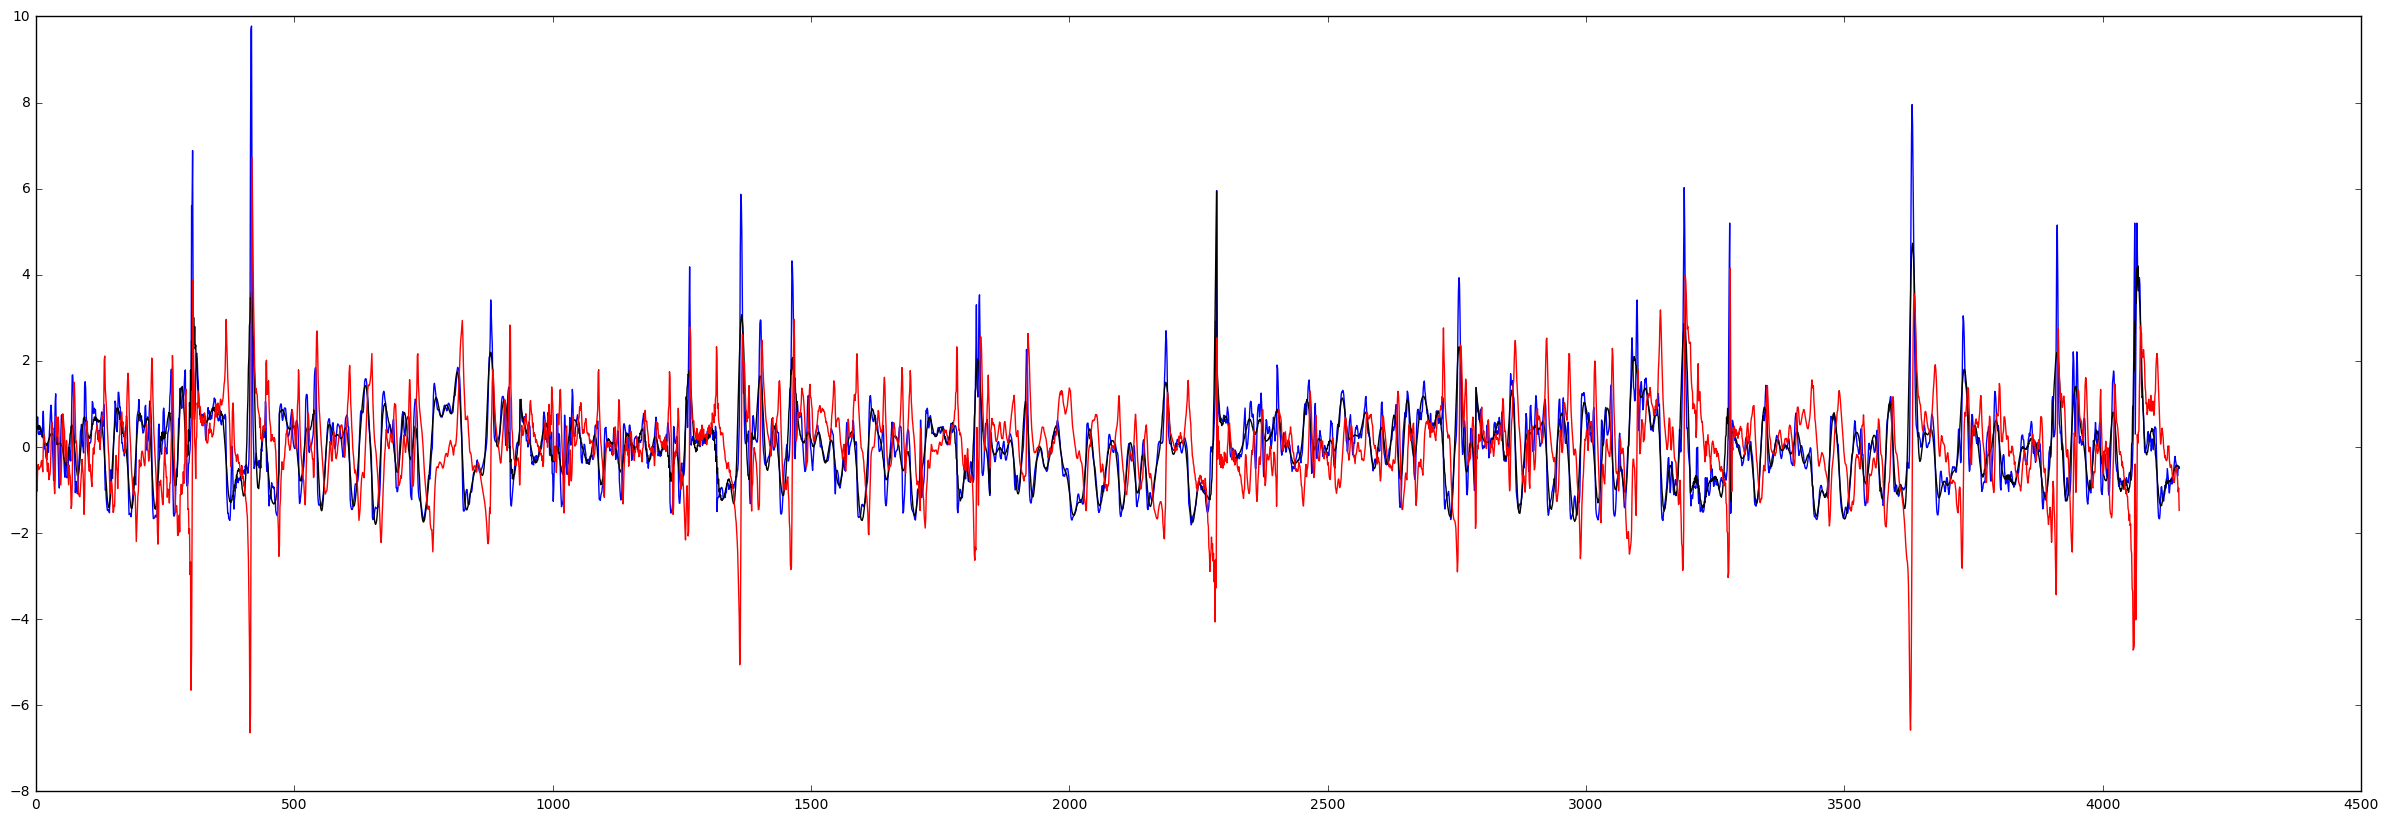

In [14]:
fig, ax = plt.subplots(figsize=(30, 10))
plt.plot(list(feature_vectors.GR)-np.mean(list(feature_vectors.GR)),color='blue')
plt.plot(list(feature_vectors.GR_smooth)-np.mean(list(feature_vectors.GR_smooth)),color='black')
plt.plot(np.imag(signal.hilbert(list(feature_vectors.GR))),color='red')


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

Now we build a pipeline and get it nice and clean:

In [15]:
#combined_features = FeatureUnion([("original_data", feature_vectors), ("univ_select", selection)])

preping = Pipeline([("imputer", preprocessing.Imputer(missing_values='NaN',strategy="mean",axis=0)),
                    ("scaling", preprocessing.StandardScaler()),
                    ("trees", RandomForestClassifier())])

preping.set_params(trees__random_state=42).fit(feature_vectors,correct_facies_labels)
score = cross_val_score(preping, feature_vectors, correct_facies_labels).mean()

preping_comp = preping
preping_comp.set_params(trees__random_state=42).fit(feature_vectors_comp,correct_facies_labels_comp)
score_comp = cross_val_score(preping, feature_vectors_comp,correct_facies_labels_comp).mean()
print("Score after preprocessing: {0} and before: {1}".format(score,score_comp))

Score after preprocessing: 0.4691750163550598 and before: 0.5049512194926891


## Training the Treeeees classifier

Now we use the cleaned and conditioned training set to create a facies classifier.  

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf  = preping.set_params(trees__random_state=42,trees__oob_score=True,trees__n_estimators=100).fit(feature_vectors,correct_facies_labels)
clf_comp = RandomForestClassifier(random_state=42,oob_score=True,n_estimators=100)

Now we can train the classifier using the training set we created above.

OOB estimate of accuracy for prospectivity classification using all features: 0.8406845022897084 and 0.7404084158415841
Feature ranking:
1. feature 54 NM_M (0.074157)
2. feature 0 GR (0.036984)
3. feature 10 GR_median (0.034362)
4. feature 22 ILD_log10_smooth_median (0.030106)
5. feature 6 PHIND (0.029298)
6. feature 18 ILD_log10_median (0.028727)
7. feature 55 RELPOS (0.025580)
8. feature 34 PHIND_median (0.025283)
9. feature 2 ILD_log10 (0.024883)
10. feature 1 GR_smooth (0.024217)
11. feature 3 ILD_log10_smooth (0.023449)
12. feature 46 PE_smooth_median (0.022895)
13. feature 42 PE_median (0.022645)
14. feature 14 GR_smooth_median (0.020980)
15. feature 30 DeltaPHI_smooth_median (0.020608)
16. feature 38 PHIND_smooth_median (0.020569)
17. feature 7 PHIND_smooth (0.019639)
18. feature 8 PE (0.018714)
19. feature 26 DeltaPHI_median (0.017810)
20. feature 9 PE_smooth (0.017506)
21. feature 5 DeltaPHI_smooth (0.017501)
22. feature 4 DeltaPHI (0.016660)
23. feature 33 DeltaPHI_smooth_ana

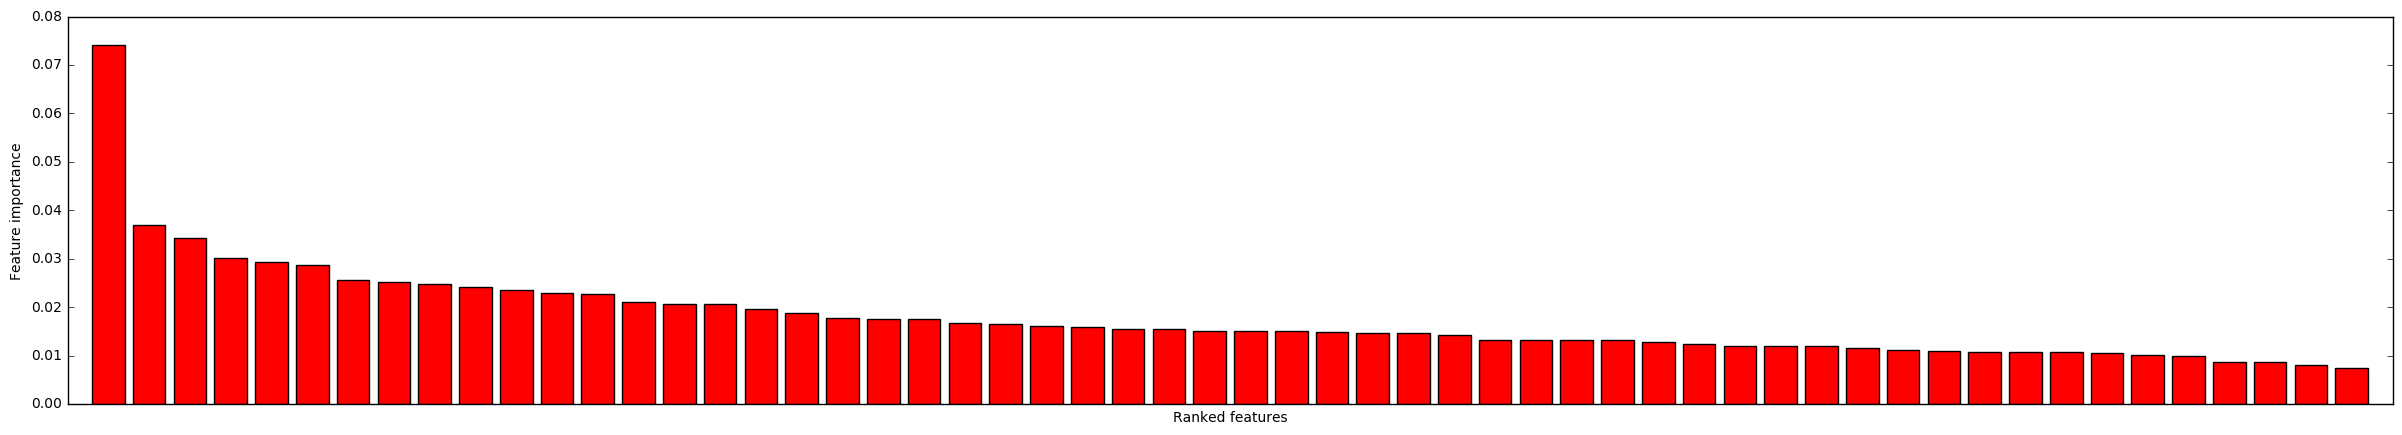

In [18]:
clf_comp.fit(scaled_features_comp,correct_facies_labels_comp)
print('OOB estimate of accuracy for prospectivity classification using all features: {0} and {1}'.format(clf.steps[2][1].oob_score_,clf_comp.oob_score_))


# Taken from Geolearn
importances = clf.steps[2][1].feature_importances_ 
std = np.std([tree.feature_importances_ for tree in clf.steps[2][1].estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
Vars = list(feature_vectors.columns.values)
for f in range(feature_vectors.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], Vars[indices[f]], importances[indices[f]]))

fig,ax = plt.subplots(figsize=(30,5))
ax.bar(range(feature_vectors.shape[1]), clf.steps[2][1].feature_importances_[indices],color="r", align="center")
plt.ylabel("Feature importance")
plt.xlabel('Ranked features')
plt.xticks([], indices)
plt.xlim([-1, feature_vectors.shape[1]]);


Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

In [19]:
predicted_labels = clf.predict(feature_vectors)
predicted_labels_comp = clf_comp.predict(scaled_features_comp)

We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

In [20]:
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, make_scorer
from classification_utilities import display_cm, display_adj_cm

In [21]:
conf = confusion_matrix(correct_facies_labels, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   268                                                   268
     CSiS         940                                             940
     FSiS               780                                       780
     SiSh                     271                                 271
       MS                           296                           296
       WS                                 582                     582
        D                                       141               141
       PS                                             686         686
       BS                                                   185   185


In [22]:
conf_comp = confusion_matrix(correct_facies_labels_comp, predicted_labels_comp)
display_cm(conf_comp, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   259                                                   259
     CSiS         738                                             738
     FSiS               615                                       615
     SiSh                     183                       1         184
       MS                           217                           217
       WS                                 461           1         462
        D                                        95           3    98
       PS                       1           1         496         498
       BS                                                   161   161


The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [23]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [24]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies,offset):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j-offset]
    return total_correct / sum(sum(conf))

In [25]:
print('Processed Full')
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies,0))

Processed Full
Facies classification accuracy = 1.000000
Adjacent facies classification accuracy = 1.000000


In [26]:
print('Non-processed')
print('Facies classification accuracy = %f' % accuracy(conf_comp))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_comp, adjacent_facies,0))

Non-processed
Facies classification accuracy = 0.997834
Adjacent facies classification accuracy = 0.998453


## Model parameter selection

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

We will consider two parameters.  The parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of C will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors.  Many kernel functions exist, but in this case we are using the radial basis function `rbf` kernel (the default).  The `gamma` parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for `C` and `gamma`.  Two nested loops are used to train a classifier for every possible combination of values in the ranges specified.  The classification accuracy is recorded for each combination of parameter values.  The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

This process is also known as 'cross validation'.  Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection.  For this tutorial we will just use the test set to choose model parameters.

In [27]:
from sklearn.model_selection import RandomizedSearchCV,LeaveOneGroupOut
from scipy.stats import randint as sp_randint

Fscorer = make_scorer(f1_score, average = 'micro')
Ascorer = make_scorer(accuracy_score)

clf = Pipeline([("imputer", preprocessing.Imputer(missing_values='NaN',strategy="mean",axis=0)),
                    ("scaling", preprocessing.StandardScaler()),
                    ("trees", RandomForestClassifier())])

clf_comp = RandomForestClassifier()

n_iter_search = 30


param_dist =  {"trees__max_depth": [np.sqrt(feature_vectors.shape[1]),np.log2(feature_vectors.shape[1]),None],
               "trees__n_estimators": sp_randint(30,200),
               "trees__max_features": sp_randint(3,feature_vectors.shape[1]), 
               "trees__min_samples_split": sp_randint(10,100), 
               "trees__min_samples_leaf": sp_randint(2,30)}

param_dist_comp =  {"max_depth": [np.sqrt(scaled_features_comp.shape[1]),np.log2(scaled_features_comp.shape[1]),None],
               "n_estimators": sp_randint(30,200),
               "max_features": sp_randint(3,scaled_features_comp.shape[1]), 
               "min_samples_split": sp_randint(10,100), 
               "min_samples_leaf": sp_randint(2,30)}

In [ ]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring = Fscorer,n_iter=n_iter_search)
random_search.fit(feature_vectors,correct_facies_labels)
print('Best score for combo: {}'.format(random_search.best_score_))
print('Best parameters for combo: {}'.format(random_search.best_params_))
clf = random_search.best_estimator_
random_search.best_estimator_

In [185]:
random_search_comp = RandomizedSearchCV(clf_comp, param_distributions=param_dist_comp,scoring = Fscorer,n_iter=n_iter_search)
random_search_comp.fit(scaled_features_comp,correct_facies_labels_comp)
print('Best score for unprocessed: {}'.format(random_search_comp.best_score_))
print('Best parameters for unprocessed: {}'.format(random_search_comp.best_params_))
clf_comp = random_search_comp.best_estimator_
random_search_comp.best_estimator_

Best score for unprocessed: 0.5402227722772277
Best parameters for unprocessed: {'min_samples_leaf': 3, 'min_samples_split': 67, 'max_depth': None, 'n_estimators': 153, 'max_features': 3}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=67, min_weight_fraction_leaf=0.0,
            n_estimators=153, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Okay, take it up a notch.

In [186]:
clf.fit(feature_vectors, correct_facies_labels)

Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('trees', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5.8073549220576037, max...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [187]:
clf_comp.fit(scaled_features_comp, correct_facies_labels_comp)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=67, min_weight_fraction_leaf=0.0,
            n_estimators=153, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [188]:
cv_conf = confusion_matrix(correct_facies_labels, clf.predict(feature_vectors))
cv_conf_comp = confusion_matrix(correct_facies_labels_comp, clf_comp.predict(scaled_features_comp))

In [189]:
print('Preprocessed')
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies,0))

Preprocessed
Optimized facies classification accuracy = 0.63
Optimized adjacent facies classification accuracy = 0.91


In [190]:
print('Unprocessed')
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_comp))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_comp, adjacent_facies,0))

Unprocessed
Optimized facies classification accuracy = 0.71
Optimized adjacent facies classification accuracy = 0.93


[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) are metrics that give more insight into how the classifier performs for individual facies.  Precision is the probability that given a classification result for a sample, the sample actually belongs to that class.  Recall is the probability that a sample will be correctly classified for a given class.

Precision and recall can be computed easily using the confusion matrix.  The code to do so has been added to the `display_confusion_matrix()` function:

In [191]:
print('Pre-processed')
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

Pre-processed
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   122   135    11                                       268
     CSiS    21   772   144                 2           1         940
     FSiS     5   290   474     1           2           8         780
     SiSh          12     2   179          59          19         271
       MS          15    11    34     1   163     1    71         296
       WS          16     5    30         375     1   155         582
        D     1    13     8     8          13    32    66         141
       PS          11    13    13         105     3   540     1   686
       BS           3                      12          57   113   185

Precision  0.82  0.61  0.71  0.68  1.00  0.51  0.86  0.59  0.99  0.68
   Recall  0.46  0.82  0.61  0.66  0.00  0.64  0.23  0.79  0.61  0.63
       F1  0.59  0.70  0.65  0.67  0.01  0.57  0.36  0.67  0.76  0.60


In [192]:
print('Un-processed')
display_cm(cv_conf_comp, facies_labels, 
           display_metrics=True, hide_zeros=True)

Un-processed
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   150    99    10                                       259
     CSiS    29   574   132                 2           1         738
     FSiS     4   118   482     3           2           6         615
     SiSh     1           4   134          35          10         184
       MS           7     6    23    48    87     7    39         217
       WS           1     1    25     5   359     3    67     1   462
        D                 1    14          11    50    20     2    98
       PS     1     1    10     9     5    79     3   384     6   498
       BS                       4          11          29   117   161

Precision  0.81  0.72  0.75  0.63  0.83  0.61  0.79  0.69  0.93  0.73
   Recall  0.58  0.78  0.78  0.73  0.22  0.78  0.51  0.77  0.73  0.71
       F1  0.68  0.75  0.76  0.68  0.35  0.69  0.62  0.73  0.82  0.70


To interpret these results, consider facies `SS`.  In our test set, if a sample was labeled `SS` the probability the sample was correct is 0.8 (precision).  If we know a sample has facies `SS`, then the probability it will be correctly labeled by the classifier is 0.78 (recall).  It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases.  The [F1 score](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure) combines both to give a single measure of relevancy of the classifier results.

These results can help guide intuition for how to improve the classifier results.  For example, for a sample with facies `MS` or mudstone, it is only classified correctly 57% of the time (recall).  Perhaps this could be improved by introducing more training samples.  Sample quality could also play a role.  Facies `BS` or bafflestone has the best `F1` score and relatively few training examples.  But this data was handpicked from other wells to provide training examples to identify this facies.

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:


In [193]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   257          11                                       268
     CSiS         937                       2           1         940
     FSiS     5         764     1           2           8         780
     SiSh          12     2   179          59          19         271
       MS          15    11         198           1    71         296
       WS          16     5    30         531                     582
        D     1    13     8     8               111               141
       PS          11    13    13                     649         686
       BS           3                      12               170   185

Precision  0.98  0.93  0.94  0.77  1.00  0.88  0.99  0.87  1.00  0.92
   Recall  0.96  1.00  0.98  0.66  0.67  0.91  0.79  0.95  0.92  0.91
       F1  0.97  0.96  0.96  0.71  0.80  0.89  0.88  0.91  0.96  0.91


In [194]:
display_adj_cm(cv_conf_comp, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   249          10                                       259
     CSiS         735                       2           1         738
     FSiS     4         600     3           2           6         615
     SiSh     1           4   134          35          10         184
       MS           7     6         158           7    39         217
       WS           1     1    25         434                 1   462
        D                 1    14                81           2    98
       PS     1     1    10     9     5               472         498
       BS                       4          11               146   161

Precision  0.98  0.99  0.95  0.71  0.97  0.90  0.92  0.89  0.98  0.93
   Recall  0.96  1.00  0.98  0.73  0.73  0.94  0.83  0.95  0.91  0.93
       F1  0.97  0.99  0.96  0.72  0.83  0.92  0.87  0.92  0.94  0.93


Considering adjacent facies, the `F1` scores for all facies types are above 0.9, except when classifying `SiSh` or marine siltstone and shale.  The classifier often misclassifies this facies (recall of 0.66), most often as wackestone. 

These results are comparable to those reported in Dubois et al. (2007).

## LOGO

In [195]:
wells = processed_data["Well Name"].values
wells_comp = training_data["Well Name"].values
logo = LeaveOneGroupOut()
logo_comp = LeaveOneGroupOut()

In [196]:
f1_SVC = []
pred = {}

X = feature_vectors.as_matrix()

for train, test in logo.split(feature_vectors, correct_facies_labels, groups=wells):
    well_name = wells[test[0]]
    clf.fit(X[train], correct_facies_labels[train])
    pred[well_name] = clf.predict(X[test])
    sc = f1_score(correct_facies_labels[test], pred[well_name], labels = np.arange(10), average = 'micro')
    print("{:>20s}  {:.3f}".format(well_name, sc))
    f1_SVC.append(sc)

print("-Average leave-one-well-out F1 Score: {0}".format(sum(f1_SVC)/(1.0*(len(f1_SVC)))))

         ALEXANDER D  0.616
     CHURCHMAN BIBLE  0.468
      CROSS H CATTLE  0.331
            KIMZEY A  0.442
            LUKE G U  0.640
               NEWBY  0.477
               NOLAN  0.525
          Recruit F9  0.425
             SHANKLE  0.499
           SHRIMPLIN  0.592
-Average leave-one-well-out F1 Score: 0.5015731728819479


In [197]:
f1_SVC_comp = []
pred_comp = {}
for train, test in logo_comp.split(scaled_features_comp, correct_facies_labels_comp, groups=wells_comp):
    well_name = wells_comp[test[0]]
    clf_comp.fit(scaled_features_comp[train], correct_facies_labels_comp[train])
    pred_comp[well_name] = clf_comp.predict(scaled_features_comp[test])
    sc = f1_score(correct_facies_labels_comp[test], pred_comp[well_name], labels = np.arange(10), average = 'micro')
    print("{:>20s}  {:.3f}".format(well_name, sc))
    f1_SVC_comp.append(sc)

print("-Average leave-one-well-out F1 Score: {0}".format(sum(f1_SVC_comp)/(1.0*(len(f1_SVC_comp)))))

     CHURCHMAN BIBLE  0.537
      CROSS H CATTLE  0.339
            LUKE G U  0.627
               NEWBY  0.492
               NOLAN  0.504
          Recruit F9  0.515
             SHANKLE  0.508
           SHRIMPLIN  0.550
-Average leave-one-well-out F1 Score: 0.5089747507406419


## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [198]:
well_data = pd.read_csv('../validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_data['NM_M'] = enc.fit(well_data[['NM_M']]).transform(well_data[['NM_M']]).toarray()
well_features = feature_eng(well_data)

The data needs to be scaled using the same constants we used for the training data.

In [199]:
well_features.describe()

,GR,GR_smooth,ILD_log10,ILD_log10_smooth,DeltaPHI,DeltaPHI_smooth,PHIND,PHIND_smooth,PE,PE_smooth,...,PE_smooth_median,PE_smooth_d1,PE_smooth_d2,PE_smooth_analytical,s2_6,s2_7,s2_8,s2_9,NM_M,RELPOS
count,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,...,830.000000,830.000000,830.000000,8.300000e+02,830.0,830.000000,830.000000,830.000000,830.000000,830.000000
mean,57.61173,57.605302,0.666312,0.666194,2.851964,2.843484,11.655277,11.661974,3.654178,3.653011,...,3.647684,-0.000277,-0.000100,1.228937e-17,0.0,1.713253,2.855422,3.997590,0.321687,0.535807
std,27.52774,23.654411,0.288367,0.269994,3.442074,3.008950,5.190236,4.118836,0.649793,0.562811,...,0.529900,0.088411,0.017546,5.525263e-01,0.0,1.485659,2.476098,3.466537,0.467405,0.283062
min,12.03600,14.298366,-0.468000,-0.396060,-8.900000,-2.747417,1.855000,1.262411,2.113000,2.184644,...,2.374134,-0.211006,-0.054247,-1.506390e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.013000
25%,36.77325,38.449529,0.541000,0.567403,0.411250,0.810261,7.700000,8.861864,3.171500,3.271645,...,3.308287,-0.058964,-0.010704,-3.492672e-01,0.0,0.000000,0.000000,0.000000,0.000000,0.300000
50%,58.34450,58.474079,0.675000,0.674013,2.397500,2.472281,10.950000,10.895321,3.515500,3.601004,...,3.590323,-0.004626,0.000588,5.473545e-02,0.0,3.000000,5.000000,7.000000,0.000000,0.547500
75%,73.05150,72.567519,0.850750,0.845201,4.600000,4.186313,14.793750,14.293305,4.191500,4.048871,...,4.035991,0.057456,0.011352,3.852650e-01,0.0,3.000000,5.000000,7.000000,1.000000,0.778000
max,220.41300,148.369276,1.507000,1.327731,16.500000,14.981416,31.335000,25.246412,6.321000,5.374079,...,5.192379,0.238965,0.041659,1.420594e+00,0.0,3.000000,5.000000,7.000000,1.000000,1.000000


Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [200]:
#predict facies of unclassified data
y_unknown = clf.predict(well_features)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1.0,1.000,1
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1.0,0.978,1
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1.0,0.956,1
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1.0,0.933,1
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1.0,0.911,1
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1.0,0.639,1
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1.0,0.611,1
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1.0,0.583,1
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1.0,0.556,1


In [201]:
well_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

We can use the well log plot to view the classification results along with the well logs.

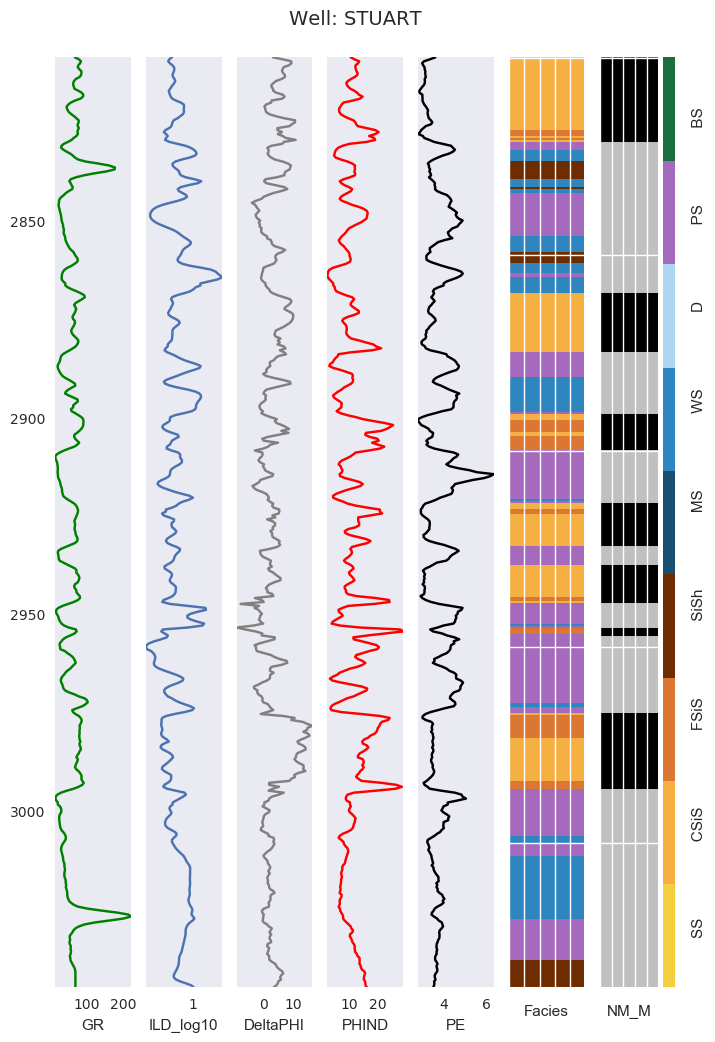

In [202]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies.Colors)

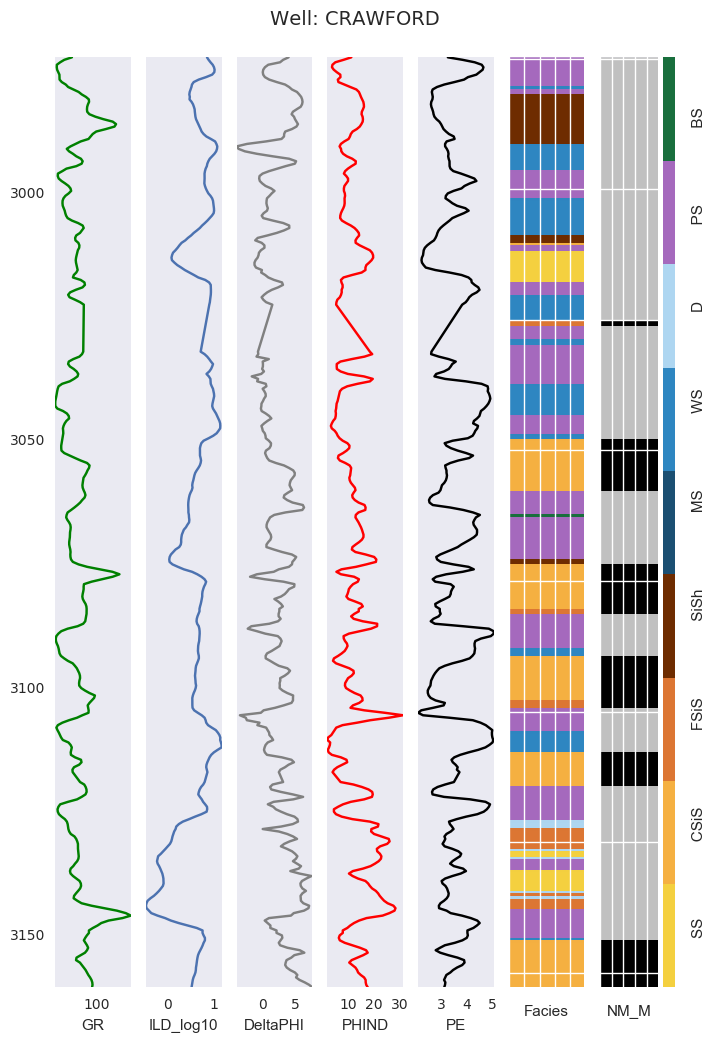

In [203]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies.Colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [204]:
well_data['Facies'] = y_unknown+1
well_data.to_csv('well_data_with_facies.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)